In [6]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.models import resnet50, vgg16, VGG16_Weights, ResNet50_Weights


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
train_data_dir = 'C:/Users/trand/CS 184A/final_project/MRI Alzhemier/AugmentedAlzheimerDataset'

#we can use this dir to for validation and testing 
test_data_dir = 'C:/Users/trand/CS 184A/final_project/MRI Alzhemier/OriginalDataset'
classes = ['MildDemented', 'ModeratedDemented', 'NonDemented', 'VeryMildDemented']


In [9]:
transform_train = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(60),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])    
}

#no flipping and rotation on dir because we want to test the raw truth - not train anymore 
transform_testval = {
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
    ])
}

In [30]:
train_dataset = datasets.ImageFolder(os.path.join(train_data_dir), transform=transform_train['train'])
test_dataset = datasets.ImageFolder(os.path.join(test_data_dir), transform=transform_testval['test'])

print(len(train_dataset))
print(len(test_dataset))
#we gonna split 50%-50% for test and validation
test_size = int(0.5 * len(test_dataset))
val_size = len(test_dataset) - test_size
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

#print(test_size, val_size)

33984
6400


In [11]:
# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:


class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()

        # Define the architecture
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Third convolutional layer
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer

        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Fully connected layer
        self.fc2 = nn.Linear(512, num_classes)  # Output layer (4 classes for Alzheimer stages)

        self.relu = nn.ReLU()  # ReLU activation
        self.dropout = nn.Dropout(0.5)  # Dropout layer to prevent overfitting

    def forward(self, x):
        # Forward pass through the network
        x = self.relu(self.conv1(x))  # First convolution + ReLU
        x = self.pool(x)  # Pooling
        x = self.relu(self.conv2(x))  # Second convolution + ReLU
        x = self.pool(x)  # Pooling
        x = self.relu(self.conv3(x))  # Third convolution + ReLU
        x = self.pool(x)  # Pooling
        
        # Flatten the tensor for the fully connected layer
        x = x.view(-1, 128 * 28 * 28)  # Flatten the output of the convolutional layers
        x = self.relu(self.fc1(x))  # Fully connected layer + ReLU
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Final output layer

        return x


In [14]:
model = CustomCNN(num_classes=4).to(device)

print(model)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Use `vgg16.parameters()` for VGG16
#steplr=torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)


In [19]:
import torch
from tqdm import tqdm

# Define train_batch function
def train_batch(batch, model, optimizer, loss_fn, device):
    data, label = batch
    model.train()
    optimizer.zero_grad()
    pred = model(data.to(device))
    loss = loss_fn(pred, label.to(device))
    acc = (torch.max(pred, 1)[1] == label.to(device)).float().mean()
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

# Define valid_batch function
@torch.no_grad()
def valid_batch(batch, model, loss_fn, device):
    data, label = batch
    model.eval()
    pred = model(data.to(device))
    loss = loss_fn(pred, label.to(device))
    acc = (torch.max(pred, 1)[1] == label.to(device)).float().mean()
    return loss.item(), acc.item()



In [20]:
# Training function with early stopping and model saving
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_fn,
    device,
    n_epoch=30,
    patience=3,
    save_path="best_model_customCNN.pth",
    scheduler=None
):
    best_val_loss = float("inf")
    patience_counter = 0

    train_losses_all = []
    val_losses_all = []
    train_accs_all = []
    val_accs_all = []


    for epoch in range(n_epoch):
        # Training phase
        train_losses, train_accs = [], []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epoch} Training"):
            loss, acc = train_batch(batch, model, optimizer, loss_fn, device)
            train_losses.append(loss)
            train_accs.append(acc)

        # Validation phase
        val_losses, val_accs = [], []
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{n_epoch} Validating"):
            loss, acc = valid_batch(batch, model, loss_fn, device)
            val_losses.append(loss)
            val_accs.append(acc)

        # Compute averages
        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_train_acc = sum(train_accs) / len(train_accs)
        avg_val_loss = sum(val_losses) / len(val_losses)
        avg_val_acc = sum(val_accs) / len(val_accs)


        train_losses_all.append(avg_train_loss)
        val_losses_all.append(avg_val_loss)
        train_accs_all.append(avg_train_acc)
        val_accs_all.append(avg_val_acc)

        print(
            f"Epoch {epoch+1}/{n_epoch} - "
            f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}"
        )

        # Early stopping
        if avg_val_loss < best_val_loss:
            print(f"Validation loss improved. Saving model to {save_path}...")
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        # Step scheduler if provided
        if scheduler:
            scheduler.step()

    print("Training complete.")

    return train_losses_all, val_losses_all, train_accs_all, val_accs_all


In [21]:
train_losses, val_losses, train_accs, val_accs = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    device=device,
    n_epoch=30,
    patience=5,
    save_path="best_model_customCNN.pth",
)




Epoch 1/30 Validating: 100%|██████████| 100/100 [00:30<00:00,  3.27it/s]


Epoch 1/30 - Train Loss: 1.1727, Train Acc: 0.4472, Val Loss: 0.9250, Val Acc: 0.5406
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 2/30 Validating: 100%|██████████| 100/100 [00:07<00:00, 12.66it/s]


Epoch 2/30 - Train Loss: 0.9374, Train Acc: 0.5733, Val Loss: 0.8993, Val Acc: 0.5559
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 3/30 Validating: 100%|██████████| 100/100 [00:09<00:00, 10.42it/s]


Epoch 3/30 - Train Loss: 0.8276, Train Acc: 0.6232, Val Loss: 0.8969, Val Acc: 0.5403
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 4/30 Validating: 100%|██████████| 100/100 [00:09<00:00, 10.77it/s]


Epoch 4/30 - Train Loss: 0.7651, Train Acc: 0.6478, Val Loss: 0.8576, Val Acc: 0.5719
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 5/30 Validating: 100%|██████████| 100/100 [00:09<00:00, 10.88it/s]


Epoch 5/30 - Train Loss: 0.7228, Train Acc: 0.6673, Val Loss: 0.7404, Val Acc: 0.6294
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 6/30 Validating: 100%|██████████| 100/100 [00:08<00:00, 11.71it/s]


Epoch 6/30 - Train Loss: 0.6888, Train Acc: 0.6856, Val Loss: 0.7089, Val Acc: 0.6622
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 7/30 Validating: 100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


Epoch 7/30 - Train Loss: 0.6614, Train Acc: 0.7001, Val Loss: 0.6948, Val Acc: 0.6728
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 8/30 Validating: 100%|██████████| 100/100 [00:09<00:00, 11.01it/s]


Epoch 8/30 - Train Loss: 0.6354, Train Acc: 0.7152, Val Loss: 0.6891, Val Acc: 0.6772
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 9/30 Validating: 100%|██████████| 100/100 [00:09<00:00, 10.07it/s]


Epoch 9/30 - Train Loss: 0.6130, Train Acc: 0.7252, Val Loss: 0.5924, Val Acc: 0.7262
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 10/30 Validating: 100%|██████████| 100/100 [00:29<00:00,  3.34it/s]


Epoch 10/30 - Train Loss: 0.5889, Train Acc: 0.7344, Val Loss: 0.5149, Val Acc: 0.7659
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 11/30 Validating: 100%|██████████| 100/100 [00:08<00:00, 11.64it/s]


Epoch 11/30 - Train Loss: 0.5642, Train Acc: 0.7480, Val Loss: 0.5379, Val Acc: 0.7619
Validation loss did not improve. Patience counter: 1/5


Epoch 12/30 Validating: 100%|██████████| 100/100 [00:07<00:00, 12.79it/s]


Epoch 12/30 - Train Loss: 0.5486, Train Acc: 0.7559, Val Loss: 0.4882, Val Acc: 0.7947
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 13/30 Validating: 100%|██████████| 100/100 [00:09<00:00, 10.60it/s]


Epoch 13/30 - Train Loss: 0.5266, Train Acc: 0.7684, Val Loss: 0.5883, Val Acc: 0.7331
Validation loss did not improve. Patience counter: 1/5


Epoch 14/30 Validating: 100%|██████████| 100/100 [00:07<00:00, 13.35it/s]


Epoch 14/30 - Train Loss: 0.5154, Train Acc: 0.7736, Val Loss: 0.5201, Val Acc: 0.7594
Validation loss did not improve. Patience counter: 2/5


Epoch 15/30 Validating: 100%|██████████| 100/100 [00:07<00:00, 12.64it/s]


Epoch 15/30 - Train Loss: 0.4963, Train Acc: 0.7831, Val Loss: 0.4660, Val Acc: 0.7859
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 16/30 Validating: 100%|██████████| 100/100 [00:08<00:00, 11.62it/s]


Epoch 16/30 - Train Loss: 0.4792, Train Acc: 0.7900, Val Loss: 0.4614, Val Acc: 0.7894
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 17/30 Validating: 100%|██████████| 100/100 [00:08<00:00, 11.97it/s]


Epoch 17/30 - Train Loss: 0.4656, Train Acc: 0.8006, Val Loss: 0.3805, Val Acc: 0.8341
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 18/30 Validating: 100%|██████████| 100/100 [00:07<00:00, 13.55it/s]


Epoch 18/30 - Train Loss: 0.4554, Train Acc: 0.8017, Val Loss: 0.4021, Val Acc: 0.8272
Validation loss did not improve. Patience counter: 1/5


Epoch 19/30 Validating: 100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


Epoch 19/30 - Train Loss: 0.4427, Train Acc: 0.8077, Val Loss: 0.3602, Val Acc: 0.8422
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 20/30 Validating: 100%|██████████| 100/100 [00:29<00:00,  3.36it/s]


Epoch 20/30 - Train Loss: 0.4310, Train Acc: 0.8132, Val Loss: 0.3332, Val Acc: 0.8678
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 21/30 Validating: 100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


Epoch 21/30 - Train Loss: 0.4168, Train Acc: 0.8218, Val Loss: 0.3253, Val Acc: 0.8556
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 22/30 Validating: 100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


Epoch 22/30 - Train Loss: 0.4056, Train Acc: 0.8240, Val Loss: 0.3129, Val Acc: 0.8691
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 23/30 Validating: 100%|██████████| 100/100 [00:07<00:00, 13.00it/s]


Epoch 23/30 - Train Loss: 0.3975, Train Acc: 0.8308, Val Loss: 0.2848, Val Acc: 0.8788
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 24/30 Validating: 100%|██████████| 100/100 [00:08<00:00, 12.06it/s]


Epoch 24/30 - Train Loss: 0.3838, Train Acc: 0.8376, Val Loss: 0.2720, Val Acc: 0.8941
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 25/30 Validating: 100%|██████████| 100/100 [00:08<00:00, 11.58it/s]


Epoch 25/30 - Train Loss: 0.3812, Train Acc: 0.8369, Val Loss: 0.2873, Val Acc: 0.8797
Validation loss did not improve. Patience counter: 1/5


Epoch 26/30 Validating: 100%|██████████| 100/100 [00:29<00:00,  3.39it/s]


Epoch 26/30 - Train Loss: 0.3703, Train Acc: 0.8408, Val Loss: 0.2833, Val Acc: 0.8853
Validation loss did not improve. Patience counter: 2/5


Epoch 27/30 Validating: 100%|██████████| 100/100 [00:07<00:00, 12.74it/s]


Epoch 27/30 - Train Loss: 0.3603, Train Acc: 0.8485, Val Loss: 0.3302, Val Acc: 0.8572
Validation loss did not improve. Patience counter: 3/5


Epoch 28/30 Validating: 100%|██████████| 100/100 [00:08<00:00, 11.91it/s]


Epoch 28/30 - Train Loss: 0.3577, Train Acc: 0.8497, Val Loss: 0.2418, Val Acc: 0.9025
Validation loss improved. Saving model to best_model_customCNN.pth...


Epoch 29/30 Validating: 100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


Epoch 29/30 - Train Loss: 0.3406, Train Acc: 0.8586, Val Loss: 0.3327, Val Acc: 0.8456
Validation loss did not improve. Patience counter: 1/5


Epoch 30/30 Validating: 100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


Epoch 30/30 - Train Loss: 0.3342, Train Acc: 0.8588, Val Loss: 0.2401, Val Acc: 0.9000
Validation loss improved. Saving model to best_model_customCNN.pth...
Training complete.


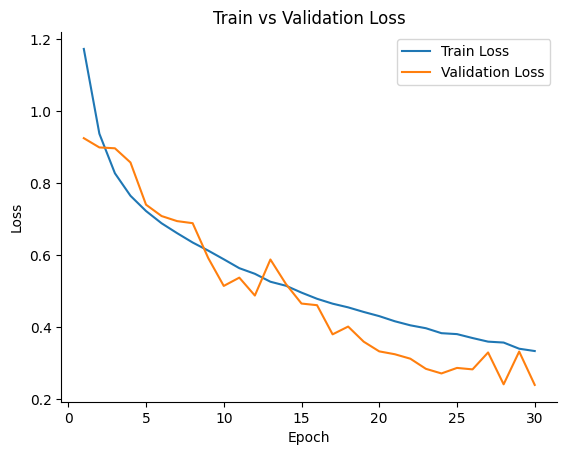

In [22]:
import matplotlib.pyplot as plt

# Plot Train and Validation Loss
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show plot
plt.show()


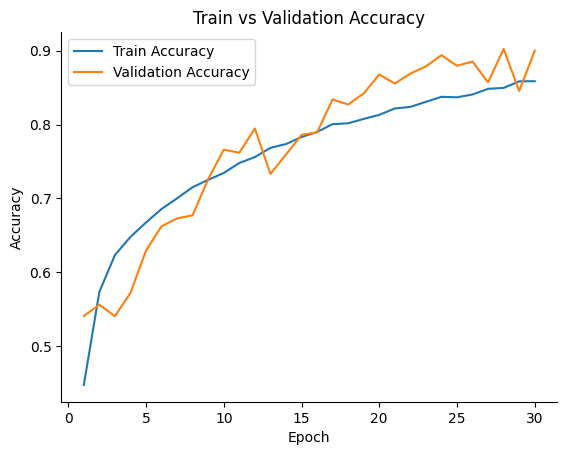

In [23]:
# Plot Train and Validation Accuracy
plt.plot(range(1, len(train_accs) + 1), train_accs, label="Train Accuracy")
plt.plot(range(1, len(val_accs) + 1), val_accs, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs Validation Accuracy')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [25]:
# evaluate resnet 

#load the model
model.load_state_dict(torch.load("./best_model_customCNN.pth"))
model.eval()  # Set the model to evaluation mode

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to evaluate the test dataset - similar to eval functions
@torch.no_grad()
def evaluate_model(model, test_loader, device):
    total = 0
    correct = 0
    all_preds = []
    all_labels = []

    for data, labels in tqdm(test_loader, desc="Testing"):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return all_preds, all_labels

# Get predictions and labels
predictions, true_labels = evaluate_model(model, test_loader, device)


Testing: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]

Test Accuracy: 0.8959


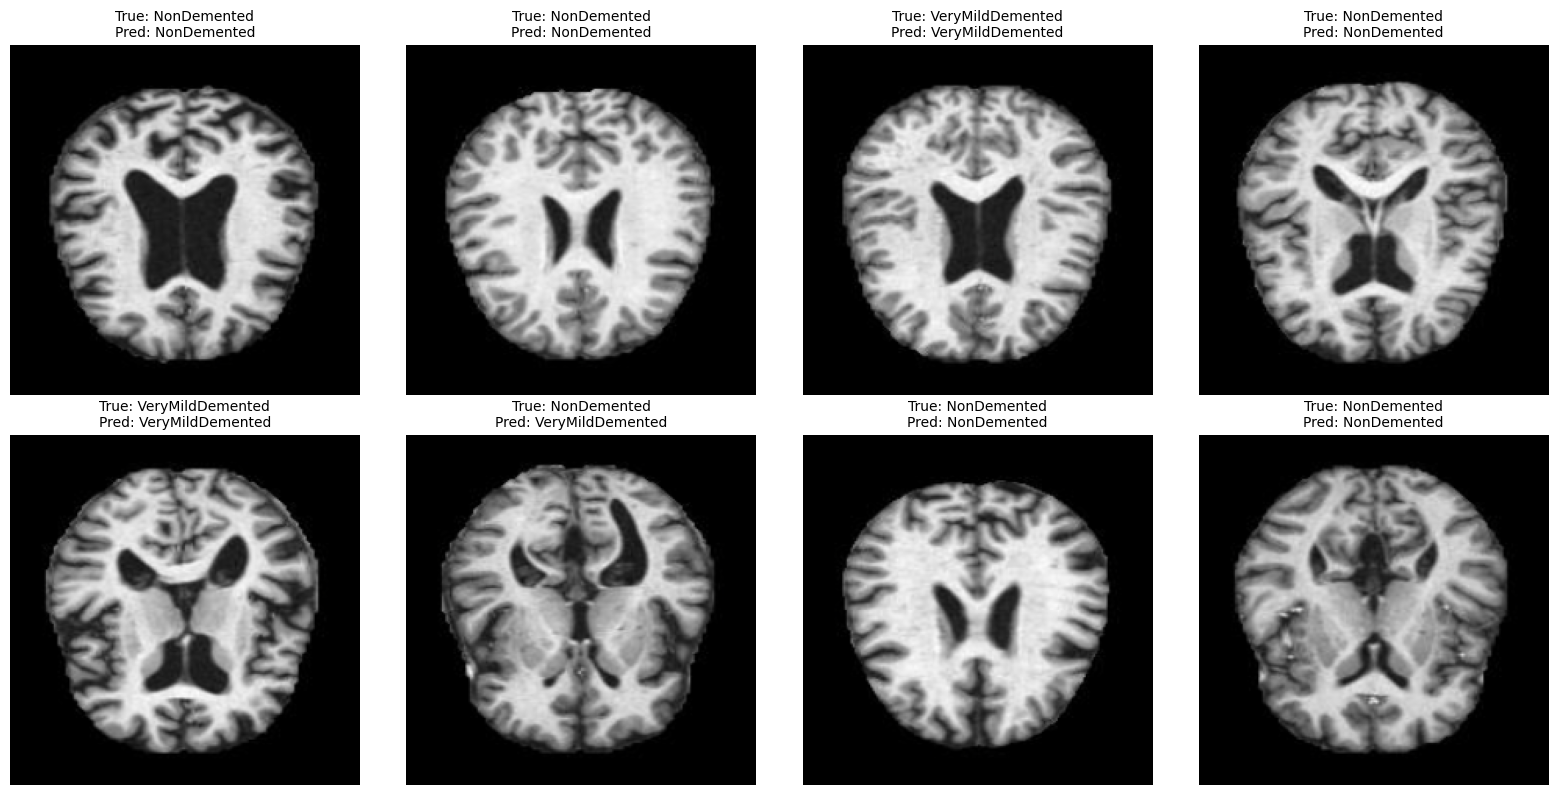

In [28]:
import random
# Visualize some test images with predicted and true labels
def display_predictions(test_loader, predictions, true_labels, classes):
        # Flatten all test data and labels for easy access
    all_data = []
    for data, _ in test_loader:
        all_data.append(data)
    all_data = torch.cat(all_data, dim=0)
    
    # Randomly select 8 indices
    num_images = 8
    random_indices = random.sample(range(len(all_data)), num_images)
    selected_images = all_data[random_indices]
    selected_preds = [predictions[i] for i in random_indices]
    selected_labels = [true_labels[i] for i in random_indices]
    
    # Unnormalize images for display
    images = selected_images.numpy().transpose((0, 2, 3, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)

    # Plot the random images with true and predicted labels
    plt.figure(figsize=(16, 8))
    for idx in range(num_images):
        plt.subplot(2, 4, idx + 1)
        plt.imshow(images[idx])
        plt.title(
            f"True: {classes[selected_labels[idx]]}\nPred: {classes[selected_preds[idx]]}",
            fontsize=10
        )
        plt.axis("off")
    plt.tight_layout()
    plt.show()
# Display predictions
display_predictions(test_loader, predictions, true_labels, classes)

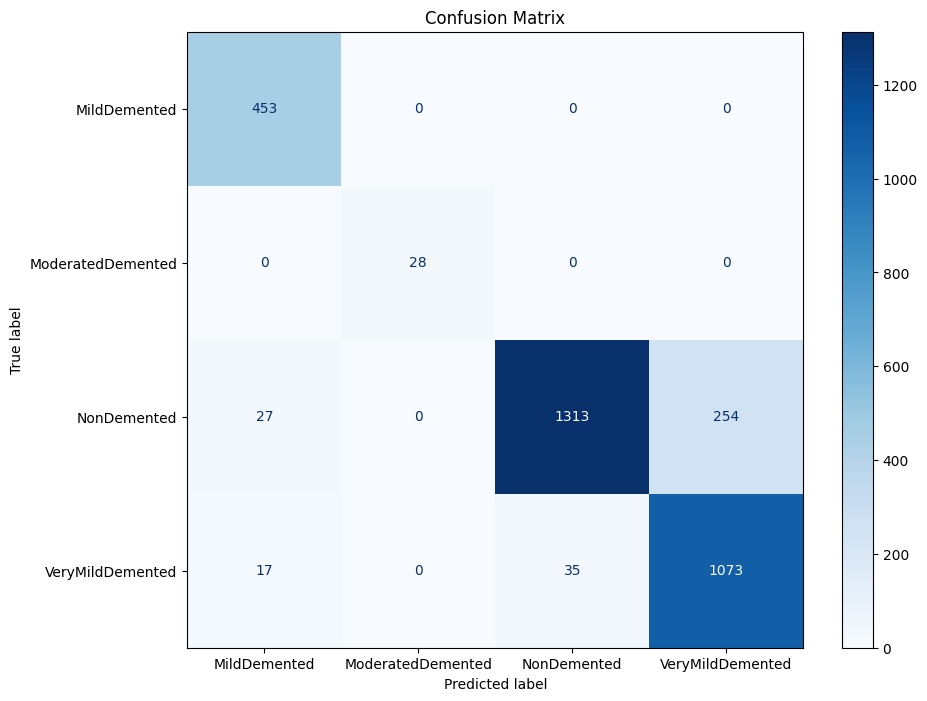

In [32]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to plot the confusion matrix
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)  # Compute the confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format="d", ax=plt.gca())
    plt.title("Confusion Matrix")
    plt.show()

# Load the class names from your dataset
#class_names = test_dataset.classes  # Update this to match your dataset

# Plot the confusion matrix
plot_confusion_matrix(true_labels, predictions, classes)
